In [1]:
import numpy as np
import os, sys
import galsim as gs
from galsim.angle import Angle, radians
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
from velocity import VelocityMap
import transformation as transform
import likelihood, cube, priors, utils, basis, parameters

plt.rcParams['axes.facecolor'] = 'w'

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
true_pars = {
    'g1': 0.05,
    'g2': -0.025,
    'theta_int': np.pi / 3,
    'sini': 0.8,
    'v0': 10.,
    'vcirc': 200,
    'rscale': 5,
}

# additional args needed for prior / likelihood evaluation
halpha = 656.28 # nm
R = 5000.
z = 0.3
pars = {
    'Nx': 30, # pixels
    'Ny': 30, # pixels
    'pix_scale': 1., # arcsec / pixel
    'true_flux': 1e5, # counts
    'true_hlr': 5, # pixels
    'v_unit': u.Unit('km / s'),
    'r_unit': u.Unit('kpc'),
    'z': z,
    'spec_resolution': R,
    'line_std': halpha * (1.+z) / R, # emission line SED std; nm
    'line_value': 656.28, # emission line SED std; nm
    'line_unit': u.Unit('nm'),
    'sed_start': 655,
    'sed_end': 657.5,
    'sed_resolution': 0.025,
    'sed_unit': u.Unit('nm'),
    'cov_sigma': 3, # pixel counts; dummy value
    'bandpass_throughput': '.2',
    'bandpass_unit': 'nm',
    'bandpass_zp': 30,
    'priors': {
        'g1': priors.GaussPrior(0., 0.3),#, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.3),#, clip_sigmas=2),
        'theta_int': priors.UniformPrior(0., np.pi),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.UniformPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10, zero_boundary='positive'),# clip_sigmas=2),
        'rscale': priors.UniformPrior(0, 10),
    },
    'intensity': {
        # For this test, use truth info
        # 'type': 'inclined_exp',
        # 'flux': 1e5, # counts
        # 'hlr': 5, # pixels
        'type': 'basis',
        'basis_type': 'sersiclets',
        'basis_kwargs': {
            'Nmax': 3,
            'plane': 'obs',
            'index': 1,
            'b': 1
            }
    },
    'marginalize_intensity': True,
    'psf': gs.Gaussian(fwhm=3), # fwhm in pixels
    'use_numba': False,
}

pars_shapelet = pars.copy()
pars_sersiclet = pars.copy()
pars_exp_shapelet = pars.copy()

nmax_cart  = 10
nmax_polar = 7
beta_shapelet = 2.8
beta_sersiclet = 5
pars_shapelet['intensity'] = {
    'type': 'basis',
    'basis_type': 'shapelets',
    'basis_kwargs': {
        'Nmax': nmax_cart,
        'beta': 3.26,
    }
}
pars_sersiclet['intensity'] = {
    'type': 'basis',
    'basis_type': 'sersiclets',
    'basis_kwargs': {
        'Nmax': nmax_polar,
        'beta': 7.29,
        'index': 1,
        'b': 1,
    }
}
pars_exp_shapelet['intensity'] = {
    'type': 'basis',
    'basis_type': 'exp_shapelets',
    'basis_kwargs': {
        'Nmax': nmax_polar,
        'beta': 0.08,
    }
}

plane = 'obs'
for p in [pars_shapelet, pars_sersiclet, pars_exp_shapelet]:
    p['intensity']['basis_kwargs']['plane'] = plane
    
sampled_pars = list(true_pars)
Pars = parameters.Pars(sampled_pars, pars)
pars_shapelet = parameters.MetaPars(pars_shapelet)
pars_sersiclet = parameters.MetaPars(pars_sersiclet)
pars_exp_shapelet = parameters.MetaPars(pars_exp_shapelet)

In [3]:
# make datavector
li, le, dl = 655.8, 656.8, 0.1
lambdas = [(l, l+dl) for l in np.arange(li, le, dl)]

bandpasses = cube.setup_simple_bandpasses(
    li, le, dl,
    throughput=pars['bandpass_throughput'],
    zp=pars['bandpass_zp'],
    unit=pars['bandpass_unit']
    )

Nx, Ny = 30, 30
Nspec = len(lambdas)
shape = (Nspec, Nx, Ny)
print('Setting up test datacube and true Halpha image')
datacube, sed, vmap, true_im = likelihood.setup_likelihood_test(
    true_pars, pars, shape, lambdas
    )

Setting up test datacube and true Halpha image


In [4]:
def make_basis_imap(theta_pars, datacube, pars):
    imap = likelihood.LogLikelihood._setup_imap(theta_pars, datacube, pars)
    i = imap.render(theta_pars, datacube, pars)
    marg = imap.fitter.compute_marginalization_det(pars=pars, log=True)
    mle = imap.fitter.mle_coefficients
    
    return i, marg, mle, imap

In [5]:
shapelet, marg_shapelet, mle_shapelet, imap_shapelet = make_basis_imap(true_pars, datacube, pars_shapelet)
sersiclet, marg_sersiclet, mle_sersiclet, imap_sersiclet = make_basis_imap(true_pars, datacube, pars_sersiclet)
exp_shapelet, marg_exp_shapelet, mle_exp_shapelet, imap_exp_shapelet = make_basis_imap(true_pars, datacube, pars_exp_shapelet)

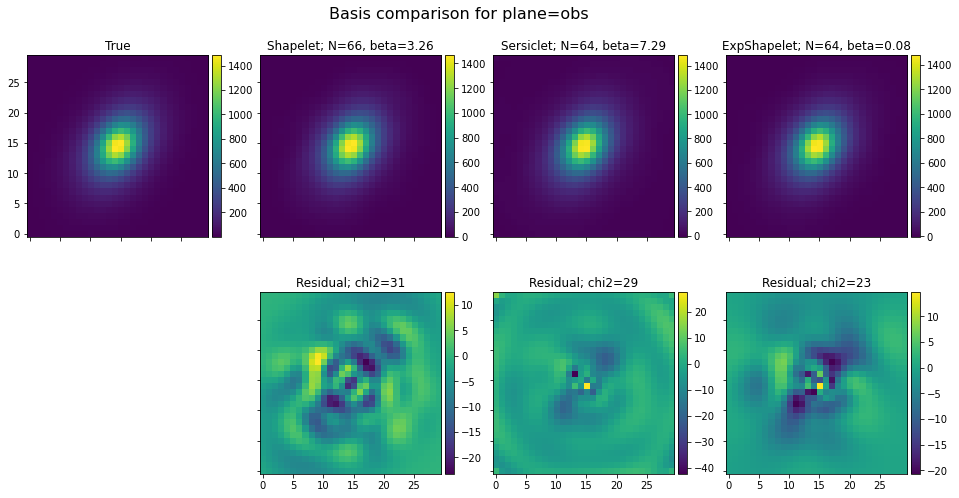

In [6]:
plt.rcParams.update({'font.size': 10})

s = (16, 8)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                         facecolor='w', figsize=s)

images = [true_im, shapelet, sersiclet, exp_shapelet,
          None, shapelet-true_im, sersiclet-true_im, exp_shapelet-true_im]

titles = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
          None, 'Residual', 'Residual', 'Residual']

names = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
        None, 'Shapelet', 'Sersiclet', 'ExpShapelet']

Nfuncs = {
    'Shapelet': len(mle_shapelet),
    'Sersiclet': len(mle_sersiclet),
    'ExpShapelet': len(mle_exp_shapelet)
}

chi2 = {
    'Shapelet': np.sum((shapelet-true_im)**2) / (Nx*Ny),
    'Sersiclet': np.sum((sersiclet-true_im)**2) / (Nx*Ny),
    'ExpShapelet': np.sum((exp_shapelet-true_im)**2) / (Nx*Ny),
}

beta = {
    'Shapelet': imap_shapelet.fitter.basis.beta,
    'Sersiclet': imap_sersiclet.fitter.basis.beta,
    'ExpShapelet': imap_exp_shapelet.fitter.basis.beta,
}

for i in range(nrows*ncols):
    ax = axes[i//ncols, i%ncols]
    if (i//ncols == 1) and (i%ncols == 0):
        ax.axis('off')
        continue
    im = ax.imshow(images[i], origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    
    if i//ncols == 1:
        c = chi2[names[i]]
    else:
        c = 0
    
    if (i//ncols == 0) and (i%ncols != 0):
        extra = f'; N={Nfuncs[titles[i]]}, beta={beta[names[i]]:.2f}'
    elif (i//ncols == 1):
        extra = f'; chi2={c:.0f}'
    else:
        extra = ''
    ax.set_title(titles[i]+extra)
    
plt.suptitle(f'Basis comparison for plane={plane}', y=0.95, fontsize=16)
plt.show()

## Visualize profiles

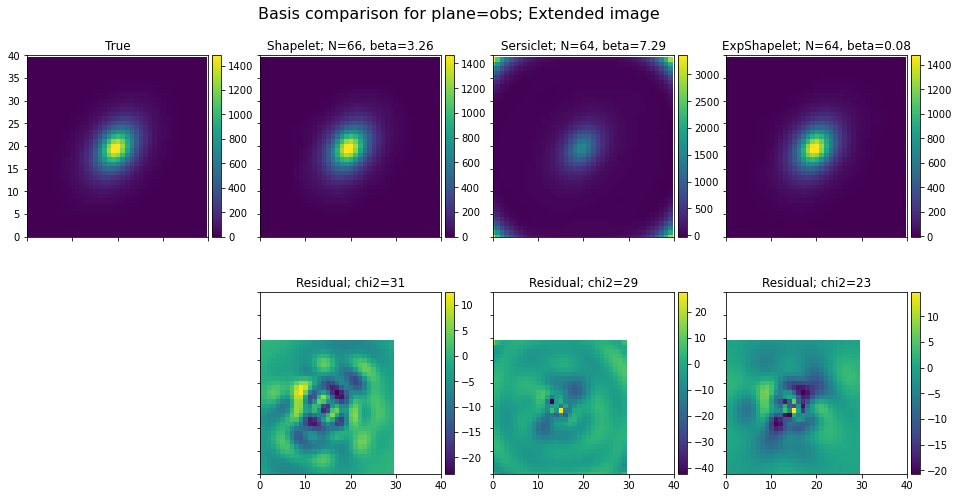

In [7]:
Nfuncs = {
    'Shapelet': len(mle_shapelet),
    'Sersiclet': len(mle_sersiclet),
    'ExpShapelet': len(mle_exp_shapelet)
}

imaps = {
    'Shapelet': imap_shapelet,
    'Sersiclet': imap_sersiclet,
    'ExpShapelet': imap_exp_shapelet
}

coefficients = {
    'Shapelet': mle_shapelet,
    'Sersiclet': mle_sersiclet,
    'ExpShapelet': mle_exp_shapelet
}

beta = {
    'Shapelet': imap_shapelet.fitter.basis.beta,
    'Sersiclet': imap_sersiclet.fitter.basis.beta,
    'ExpShapelet': imap_exp_shapelet.fitter.basis.beta,
}

titles = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
          None, 'Residual', 'Residual', 'Residual']

names = ['True', 'Shapelet', 'Sersiclet', 'ExpShapelet',
        None, 'Shapelet', 'Sersiclet', 'ExpShapelet']

im_shape = (40,40)

cmap = None

true_im_big = np.zeros(im_shape)

diff_x = im_shape[0]-Nx
diff_y = im_shape[1]-Ny
start_x = diff_x//2
start_y = diff_y//2
true_im_big[start_x:start_x+Nx, start_y:start_y+Ny] = true_im
        
images = [true_im, shapelet, sersiclet, exp_shapelet,
          None, shapelet-true_im, sersiclet-true_im, exp_shapelet-true_im]

plt.rcParams.update({'font.size': 10})

s = (16, 8)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                         facecolor='w', figsize=s)

# for name, nfuncs in Nfuncs.items():

for i in range(nrows*ncols):
    ax = axes[i//ncols, i%ncols]
    if (i//ncols == 1) and (i%ncols == 0):
        ax.axis('off')
        continue
        
    if i == 0:
        im = ax.imshow(true_im_big, origin='lower', cmap=cmap)
        ax.set_title(titles[i])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(im, cax=cax)
        continue
        
    name = names[i]
    coeff = coefficients[name]
    
    if i//ncols==0:
        im = ax.imshow(
            imaps[name].fitter.basis.render_im(true_pars, coeff, im_shape=im_shape),
            origin='lower',
            cmap=cmap)
    else:
        im = ax.imshow(images[i], origin='lower', cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    
    ax.set_xlim(0, im_shape[0])
    ax.set_ylim(0, im_shape[1])
    
    if i//ncols == 1:
        c = chi2[names[i]]
    else:
        c = 0
    
    if (i//ncols == 0) and (i%ncols != 0):
        extra = f'; N={Nfuncs[titles[i]]}, beta={beta[names[i]]:.2f}'
    elif (i//ncols == 1):
        extra = f'; chi2={c:.0f}'
    else:
        extra = ''
    ax.set_title(titles[i]+extra)
    
plt.suptitle(f'Basis comparison for plane={plane}; Extended image', y=0.95, fontsize=16)
plt.show()

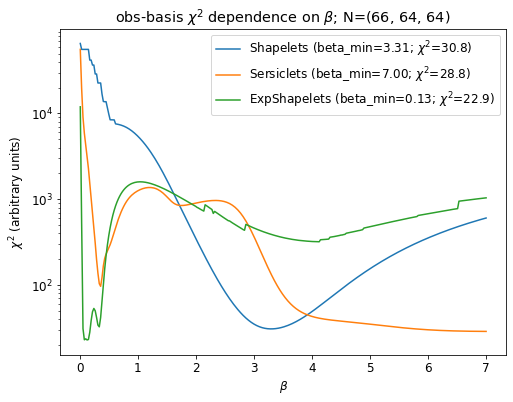

In [10]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.facecolor'] = 'w'

pars_shapelet_b = pars_shapelet.copy()
pars_sersiclet_b = pars_sersiclet.copy()
pars_exp_shapelet_b = pars_exp_shapelet.copy()


Nbetas = 300
betas = np.linspace(0.01, 7, Nbetas)

shapelet_chi2 = np.zeros(Nbetas)
sersiclet_chi2 = np.zeros(Nbetas)
exp_shapelet_chi2 = np.zeros(Nbetas)

fig = plt.plot(facecolor='w')

for i, beta in enumerate(betas):
    pars_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_sersiclet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_exp_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    
    shapelet, _, shapelet_mle = make_basis_imap(true_pars, datacube, pars_shapelet_b)[0:3]
    sersiclet, _, sersiclet_mle = make_basis_imap(true_pars, datacube, pars_sersiclet_b)[0:3]
    exp_shapelet, _, exp_shapelet_mle = make_basis_imap(true_pars, datacube, pars_exp_shapelet_b)[0:3]
    
    shapelet_chi2[i] = np.sum((shapelet-true_im)**2 / (Nx*Ny))
    sersiclet_chi2[i] = np.sum((sersiclet-true_im)**2 / (Nx*Ny))
    exp_shapelet_chi2[i] = np.sum((exp_shapelet-true_im)**2 / (Nx*Ny))
    
shapelet_min = betas[np.argmin(shapelet_chi2)]
sersiclet_min = betas[np.argmin(sersiclet_chi2)]
exp_shapelet_min = betas[np.argmin(exp_shapelet_chi2)]

shapelet_min_chi2 = np.min(shapelet_chi2)
sersiclet_min_chi2 = np.min(sersiclet_chi2)
exp_shapelet_min_chi2 = np.min(exp_shapelet_chi2)

# fig, axes = plt.subplots(111, facecolor='w', figsize=(8,6))
    
# ax = axes[0]
plt.plot(betas, shapelet_chi2, label=f'Shapelets (beta_min={shapelet_min:.2f}; $\chi^2$={shapelet_min_chi2:.1f})')
plt.plot(betas, sersiclet_chi2, label=f'Sersiclets (beta_min={sersiclet_min:.2f}; $\chi^2$={sersiclet_min_chi2:.1f})')
plt.plot(betas, exp_shapelet_chi2, label=f'ExpShapelets (beta_min={exp_shapelet_min:.2f}; $\chi^2$={exp_shapelet_min_chi2:.1f})')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\chi^2$ (arbitrary units)')      
plt.yscale('log')
plt.axhline(0, lw=2, c='k')

nfuncs = (len(shapelet_mle), len(sersiclet_mle), len(exp_shapelet_mle))
plt.title(rf'{plane}-basis $\chi^2$ dependence on $\beta$; N={nfuncs}')

plt.gcf().patch.set_facecolor('w')
plt.gcf().set_size_inches(8,6)

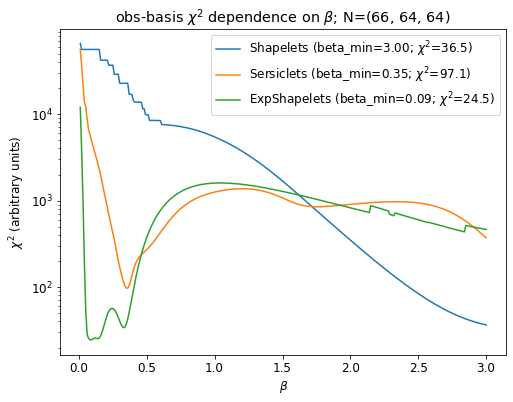

In [57]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.facecolor'] = 'w'

pars_shapelet_b = pars_shapelet.copy()
pars_sersiclet_b = pars_sersiclet.copy()
pars_exp_shapelet_b = pars_exp_shapelet.copy()


Nbetas = 300
betas = np.linspace(0.01, 3, Nbetas)

shapelet_chi2 = np.zeros(Nbetas)
sersiclet_chi2 = np.zeros(Nbetas)
exp_shapelet_chi2 = np.zeros(Nbetas)

fig = plt.plot(facecolor='w')

for i, beta in enumerate(betas):
    pars_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_sersiclet_b['intensity']['basis_kwargs']['beta'] = beta
    pars_exp_shapelet_b['intensity']['basis_kwargs']['beta'] = beta
    
    shapelet, _, shapelet_mle = make_basis_imap(true_pars, datacube, pars_shapelet_b)[0:3]
    sersiclet, _, sersiclet_mle = make_basis_imap(true_pars, datacube, pars_sersiclet_b)[0:3]
    exp_shapelet, _, exp_shapelet_mle = make_basis_imap(true_pars, datacube, pars_exp_shapelet_b)[0:3]
    
    shapelet_chi2[i] = np.sum((shapelet-true_im)**2 / (Nx*Ny))
    sersiclet_chi2[i] = np.sum((sersiclet-true_im)**2 / (Nx*Ny))
    exp_shapelet_chi2[i] = np.sum((exp_shapelet-true_im)**2 / (Nx*Ny))
    
shapelet_min = betas[np.argmin(shapelet_chi2)]
sersiclet_min = betas[np.argmin(sersiclet_chi2)]
exp_shapelet_min = betas[np.argmin(exp_shapelet_chi2)]

shapelet_min_chi2 = np.min(shapelet_chi2)
sersiclet_min_chi2 = np.min(sersiclet_chi2)
exp_shapelet_min_chi2 = np.min(exp_shapelet_chi2)

# fig, axes = plt.subplots(111, facecolor='w', figsize=(8,6))
    
# ax = axes[0]
plt.plot(betas, shapelet_chi2, label=f'Shapelets (beta_min={shapelet_min:.2f}; $\chi^2$={shapelet_min_chi2:.1f})')
plt.plot(betas, sersiclet_chi2, label=f'Sersiclets (beta_min={sersiclet_min:.2f}; $\chi^2$={sersiclet_min_chi2:.1f})')
plt.plot(betas, exp_shapelet_chi2, label=f'ExpShapelets (beta_min={exp_shapelet_min:.2f}; $\chi^2$={exp_shapelet_min_chi2:.1f})')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\chi^2$ (arbitrary units)')      
plt.yscale('log')
plt.axhline(0, lw=2, c='k')

nfuncs = (len(shapelet_mle), len(sersiclet_mle), len(exp_shapelet_mle))
plt.title(rf'{plane}-basis $\chi^2$ dependence on $\beta$; N={nfuncs}')

plt.gcf().patch.set_facecolor('w')
plt.gcf().set_size_inches(8,6)